#LSTM for Time Series Prediction

The problem you will look at in this post is the international airline passengers prediction problem. This is a problem where, given a year and a month, the task is to predict the number of international airline passengers in units of 1,000. The data ranges from January 1949 to December 1960, or 12 years, with 144 observations

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

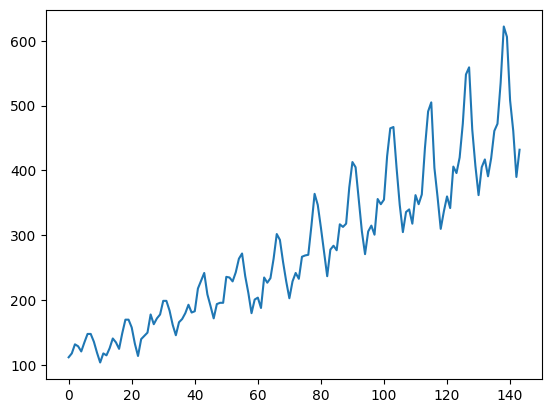

In [11]:
df = pd.read_csv('AirPassengers.csv')
timeseries = df[["#Passengers"]].values.astype('float32')

plt.plot(timeseries)
plt.show()

In [12]:
# train-test split for time series
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

The more complicated problem is how do you want the network to predict the time series. Usually time series prediction is done on a window. That is, given data from time t - w to time t, you are asked to predict for time t + 1 (or deeper into the future). The size of window governs how much data you are allowed to look at when you make the prediction. This is also called the look back period.

In [13]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([92, 4, 1]) torch.Size([92, 4, 1])
torch.Size([44, 4, 1]) torch.Size([44, 4, 1])


In [14]:
class my_LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

#Training and Verifying Your LSTM Network


In [15]:
model = my_LSTM()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 226.1269, test RMSE 425.3568
Epoch 100: train RMSE 177.4998, test RMSE 374.3618
Epoch 200: train RMSE 139.6853, test RMSE 332.9278
Epoch 300: train RMSE 109.6083, test RMSE 296.9552
Epoch 400: train RMSE 86.8514, test RMSE 264.9177
Epoch 500: train RMSE 66.3035, test RMSE 233.1520
Epoch 600: train RMSE 52.0875, test RMSE 205.6685
Epoch 700: train RMSE 41.9462, test RMSE 181.5873
Epoch 800: train RMSE 34.9568, test RMSE 160.7354
Epoch 900: train RMSE 30.6852, test RMSE 142.8285
Epoch 1000: train RMSE 26.9233, test RMSE 128.0597
Epoch 1100: train RMSE 24.9225, test RMSE 116.1500
Epoch 1200: train RMSE 23.1268, test RMSE 105.5572
Epoch 1300: train RMSE 22.1503, test RMSE 97.9232
Epoch 1400: train RMSE 21.1232, test RMSE 92.1686
Epoch 1500: train RMSE 21.2953, test RMSE 87.0687
Epoch 1600: train RMSE 20.1801, test RMSE 83.7248
Epoch 1700: train RMSE 19.7091, test RMSE 80.3370
Epoch 1800: train RMSE 19.4107, test RMSE 78.5931
Epoch 1900: train RMSE 19.3112, test RMSE 75.

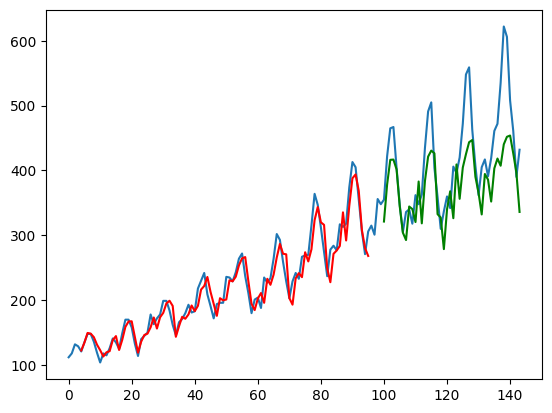

In [16]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]


# plot
plt.plot(timeseries)
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()